# Graph Neural Network for DDI Prediction

In [79]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader

from torch_geometric.data import HeteroData
import torch_geometric.transforms as T
from torch_geometric.nn import SAGEConv

from torch_geometric.utils import negative_sampling

from ogb.linkproppred import Evaluator, PygLinkPropPredDataset

import matplotlib.pyplot as plt

### Load OGB Dataset

In [2]:
dataset = PygLinkPropPredDataset(name='ogbl-ddi', transform=T.ToSparseTensor())
    
split_edge = dataset.get_edge_split()
train_edge, valid_edge, test_edge = split_edge["train"], split_edge["valid"], split_edge["test"]

# # add relation type - interacts with
# train = train_edge['edge']
# train = torch.tensor([[x[0], 0, x[1]] for x in train])

# valid = valid_edge['edge']
# valid = torch.tensor([[x[0], 0, x[1]] for x in valid])

# valid_neg = valid_edge['edge_neg']
# valid_neg = torch.tensor([[x[0], 0, x[1]] for x in valid_neg])

# test = test_edge['edge']
# test = torch.tensor([[x[0], 0, x[1]] for x in test])

# test_neg = test_edge['edge_neg']
# test_neg = torch.tensor([[x[0], 0, x[1]] for x in test_neg])

# print('Train data size:', train.shape[0])
# print('Valid-pos data size:', valid.shape[0])
# print('Valid-neg data size:', valid_neg.shape[0])
# print('Test-pos data size:', test.shape[0])
# print('Test-neg data size:', test_neg.shape[0])

In [5]:
train_edge['edge'].shape

torch.Size([1067911, 2])

## Model

https://github.com/snap-stanford/ogb/blob/master/examples/linkproppred/ddi/gnn.py

In [47]:
class GNNStack(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, dropout, emb=False):
        super(GNNStack, self).__init__()

        self.convs = torch.nn.ModuleList()
        self.convs.append(SAGEConv(input_dim, hidden_dim))
        self.dropout = dropout
        self.num_layers = num_layers
        self.emb = emb

        assert (self.num_layers >= 1), 'Number of layers is not >=1'
        for l in range(self.num_layers - 1):
            self.convs.append(SAGEConv(hidden_dim, hidden_dim))

        # post-message-passing
        self.post_mp = torch.nn.Sequential(
            torch.nn.Linear(hidden_dim, hidden_dim), torch.nn.Dropout(self.dropout),
            torch.nn.Linear(hidden_dim, output_dim))
        
    def reset_parameters(self):
        for conv in self.convs:
            conv.reset_parameters()    

    def forward(self, x, edge_index):
        for i in range(self.num_layers):
            x = self.convs[i](x, edge_index)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)

        x = self.post_mp(x)

        # Return node embeddings after post-message passing if specified
        if self.emb:
            return x

        # Else return class probabilities for each node
        return F.log_softmax(x, dim=1)

    def loss(self, pred, label):
        return F.nll_loss(pred, label)

In [23]:
class LinkPredictor(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers,
                 dropout):
        super(LinkPredictor, self).__init__()

        self.lins = torch.nn.ModuleList()
        self.lins.append(torch.nn.Linear(in_channels, hidden_channels))
        for _ in range(num_layers - 2):
            self.lins.append(torch.nn.Linear(hidden_channels, hidden_channels))
        self.lins.append(torch.nn.Linear(hidden_channels, out_channels))

        self.dropout = dropout

    def reset_parameters(self):
        for lin in self.lins:
            lin.reset_parameters()

    def forward(self, x_i, x_j):
        x = x_i * x_j
        for lin in self.lins[:-1]:
            x = lin(x)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.lins[-1](x)
        return torch.sigmoid(x)

In [37]:
def train(model, predictor, x, adj_t, split_edge, optimizer, batch_size):

    row, col, _ = adj_t.coo()
    edge_index = torch.stack([col, row], dim=0)

    model.train()
    predictor.train()

    pos_train_edge = split_edge['train']['edge'].to(x.device)

    total_loss = total_examples = 0
    for perm in DataLoader(range(pos_train_edge.size(0)), batch_size, shuffle=True):
        optimizer.zero_grad()

        h = model(x, adj_t)

        edge = pos_train_edge[perm].t()

        pos_out = predictor(h[edge[0]], h[edge[1]])
        pos_loss = -torch.log(pos_out + 1e-15).mean()

        edge = negative_sampling(edge_index, num_nodes=x.size(0),
                                 num_neg_samples=perm.size(0), method='dense')

        neg_out = predictor(h[edge[0]], h[edge[1]])
        neg_loss = -torch.log(1 - neg_out + 1e-15).mean()

        loss = pos_loss + neg_loss
        loss.backward()

        torch.nn.utils.clip_grad_norm_(x, 1.0)
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        torch.nn.utils.clip_grad_norm_(predictor.parameters(), 1.0)

        optimizer.step()

        num_examples = pos_out.size(0)
        total_loss += loss.item() * num_examples
        total_examples += num_examples

    return total_loss / total_examples

In [39]:
@torch.no_grad()
def test(model, predictor, x, adj_t, split_edge, evaluator, batch_size):
    model.eval()
    predictor.eval()

    h = model(x, adj_t)

    pos_train_edge = split_edge['eval_train']['edge'].to(x.device)
    pos_valid_edge = split_edge['valid']['edge'].to(x.device)
    neg_valid_edge = split_edge['valid']['edge_neg'].to(x.device)
    pos_test_edge = split_edge['test']['edge'].to(x.device)
    neg_test_edge = split_edge['test']['edge_neg'].to(x.device)

    pos_train_preds = []
    for perm in DataLoader(range(pos_train_edge.size(0)), batch_size):
        edge = pos_train_edge[perm].t()
        pos_train_preds += [predictor(h[edge[0]], h[edge[1]]).squeeze().cpu()]
    pos_train_pred = torch.cat(pos_train_preds, dim=0)

    pos_valid_preds = []
    for perm in DataLoader(range(pos_valid_edge.size(0)), batch_size):
        edge = pos_valid_edge[perm].t()
        pos_valid_preds += [predictor(h[edge[0]], h[edge[1]]).squeeze().cpu()]
    pos_valid_pred = torch.cat(pos_valid_preds, dim=0)

    neg_valid_preds = []
    for perm in DataLoader(range(neg_valid_edge.size(0)), batch_size):
        edge = neg_valid_edge[perm].t()
        neg_valid_preds += [predictor(h[edge[0]], h[edge[1]]).squeeze().cpu()]
    neg_valid_pred = torch.cat(neg_valid_preds, dim=0)

    pos_test_preds = []
    for perm in DataLoader(range(pos_test_edge.size(0)), batch_size):
        edge = pos_test_edge[perm].t()
        pos_test_preds += [predictor(h[edge[0]], h[edge[1]]).squeeze().cpu()]
    pos_test_pred = torch.cat(pos_test_preds, dim=0)

    neg_test_preds = []
    for perm in DataLoader(range(neg_test_edge.size(0)), batch_size):
        edge = neg_test_edge[perm].t()
        neg_test_preds += [predictor(h[edge[0]], h[edge[1]]).squeeze().cpu()]
    neg_test_pred = torch.cat(neg_test_preds, dim=0)

    results = {}
    for K in [10, 20, 30]:
        evaluator.K = K
        train_hits = evaluator.eval({
            'y_pred_pos': pos_train_pred,
            'y_pred_neg': neg_valid_pred,
        })[f'hits@{K}']
        valid_hits = evaluator.eval({
            'y_pred_pos': pos_valid_pred,
            'y_pred_neg': neg_valid_pred,
        })[f'hits@{K}']
        test_hits = evaluator.eval({
            'y_pred_pos': pos_test_pred,
            'y_pred_neg': neg_test_pred,
        })[f'hits@{K}']

        results[f'Hits@{K}'] = (train_hits, valid_hits, test_hits)

    return results

In [104]:
# hyperparametres

hidden_channels = 96
nodes_emb = 256
num_layers = 2
dropout = 0.2
lr = 0.001
num_epochs = 100
batch_size = 1024

eval_steps = 1
log_steps = 10

In [105]:
device = torch.device('cuda')

data = dataset[0]
adj_t = data.adj_t.to(device)

split_edge = dataset.get_edge_split()

evaluator = Evaluator(name='ogbl-ddi')

# We randomly pick some training samples that we want to evaluate on:
torch.manual_seed(12345)
idx = torch.randperm(split_edge['train']['edge'].size(0))
idx = idx[:split_edge['valid']['edge'].size(0)]
split_edge['eval_train'] = {'edge': split_edge['train']['edge'][idx]}

emb = torch.nn.Embedding(data.adj_t.size(0), nodes_emb).to(device)
predictor = LinkPredictor(hidden_channels, hidden_channels, 1, num_layers, dropout).to(device)

model = GNNStack(nodes_emb, hidden_channels, hidden_channels, num_layers, dropout).to(device)

print('Number of parameters:',
          sum(p.numel() for p in list(model.parameters()) +
          list(predictor.parameters()) + list(emb.parameters())))


Number of parameters: 1188161


In [106]:
history = {'loss': [], 'hits@20': []}

for run in range(1):
    torch.nn.init.xavier_uniform_(emb.weight)
    model.reset_parameters()
    predictor.reset_parameters()
    optimizer = torch.optim.Adam(
        list(model.parameters()) + list(emb.parameters()) +
        list(predictor.parameters()), lr=lr)

    for epoch in range(1, 1 + num_epochs):
        loss = train(model, predictor, emb.weight, adj_t, split_edge, optimizer, batch_size)
        history['loss'].append(loss)
        
        if epoch % eval_steps == 0:
            results = test(model, predictor, emb.weight, adj_t, split_edge, evaluator, batch_size)
#             for key, result in results.items():
#                 print('Run:', run, 'Result:', result)
            history['hits@20'].append(results['Hits@20'])

            if epoch % log_steps == 0:
                for key, result in results.items():
                    train_hits, valid_hits, test_hits = result
                    print(key)
                    print(f'Run: {run + 1:02d}, '
                          f'Epoch: {epoch:02d}, '
                          f'Loss: {loss:.4f}, '
                          f'Train: {100 * train_hits:.2f}%, '
                          f'Valid: {100 * valid_hits:.2f}%, '
                          f'Test: {100 * test_hits:.2f}%')
                print('---')


Hits@10
Run: 01, Epoch: 10, Loss: 0.4304, Train: 30.80%, Valid: 27.69%, Test: 17.51%
Hits@20
Run: 01, Epoch: 10, Loss: 0.4304, Train: 35.49%, Valid: 32.32%, Test: 24.00%
Hits@30
Run: 01, Epoch: 10, Loss: 0.4304, Train: 39.82%, Valid: 36.79%, Test: 28.49%
---
Hits@10
Run: 01, Epoch: 20, Loss: 0.3953, Train: 29.77%, Valid: 26.40%, Test: 20.56%
Hits@20
Run: 01, Epoch: 20, Loss: 0.3953, Train: 36.49%, Valid: 32.52%, Test: 28.76%
Hits@30
Run: 01, Epoch: 20, Loss: 0.3953, Train: 39.45%, Valid: 35.37%, Test: 32.82%
---
Hits@10
Run: 01, Epoch: 30, Loss: 0.3769, Train: 29.17%, Valid: 25.63%, Test: 6.36%
Hits@20
Run: 01, Epoch: 30, Loss: 0.3769, Train: 37.80%, Valid: 33.55%, Test: 13.37%
Hits@30
Run: 01, Epoch: 30, Loss: 0.3769, Train: 41.60%, Valid: 37.08%, Test: 21.25%
---
Hits@10
Run: 01, Epoch: 40, Loss: 0.3636, Train: 33.58%, Valid: 29.97%, Test: 12.09%
Hits@20
Run: 01, Epoch: 40, Loss: 0.3636, Train: 39.22%, Valid: 35.01%, Test: 18.22%
Hits@30
Run: 01, Epoch: 40, Loss: 0.3636, Train: 42.20

In [107]:
gnn_dir = 'trained_gnn/'

torch.save(model.state_dict(), gnn_dir + 'model_weights.pth')
torch.save(predictor.state_dict(), gnn_dir + 'predictor_weights.pth')
torch.save(emb.state_dict(), gnn_dir + 'embedding_weights.pth')

In [102]:
# model.load_state_dict(torch.load(gnn_dir + 'model_weights.pth'))

<All keys matched successfully>

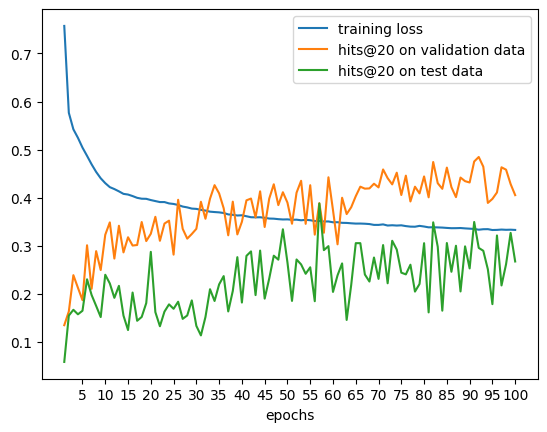

In [108]:
hits_val = [x[1] for x in history['hits@20']]
hits_test = [x[2] for x in history['hits@20']]
epochs = range(1, num_epochs+1)

plt.plot(epochs, history['loss'], label = "training loss")
plt.plot(epochs, hits_val, label = "hits@20 on validation data")
plt.plot(epochs, hits_test, label = "hits@20 on test data")
plt.xticks([e for e in epochs if e % 5 == 0])
plt.legend()
plt.xlabel('epochs')
plt.show()